In [8]:
import os
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchmetrics.functional import structural_similarity_index_measure as ssim
from importnb import Notebook
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import config
import models

with Notebook():
    from jetbot_dataset import JetbotDatasetimport datetime


In [9]:
def load_sampler(checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    inner_cfg = models.InnerModelConfig(
        img_channels=config.DM_IMG_CHANNELS,
        num_steps_conditioning=config.DM_NUM_STEPS_CONDITIONING,
        cond_channels=config.DM_COND_CHANNELS,
        depths=config.DM_UNET_DEPTHS,
        channels=config.DM_UNET_CHANNELS,
        attn_depths=config.DM_UNET_ATTN_DEPTHS,
        num_actions=config.DM_NUM_ACTIONS,
        is_upsampler=config.DM_IS_UPSAMPLER,
    )
    denoiser_cfg = models.DenoiserConfig(
        inner_model=inner_cfg,
        sigma_data=config.DM_SIGMA_DATA,
        sigma_offset_noise=config.DM_SIGMA_OFFSET_NOISE,
        noise_previous_obs=config.DM_NOISE_PREVIOUS_OBS,
        upsampling_factor=config.DM_UPSAMPLING_FACTOR,
    )
    denoiser = models.Denoiser(cfg=denoiser_cfg).to(device)
    denoiser.load_state_dict(checkpoint["model_state_dict"])
    denoiser.eval()
    sampler_cfg = models.DiffusionSamplerConfig(
        num_steps_denoising=config.SAMPLER_NUM_STEPS,
        sigma_min=config.SAMPLER_SIGMA_MIN,
        sigma_max=config.SAMPLER_SIGMA_MAX,
        rho=config.SAMPLER_RHO,
        order=getattr(config, "SAMPLER_ORDER", 1),
        s_churn=getattr(config, "SAMPLER_S_CHURN", 0.0),
    )
    return models.DiffusionSampler(denoiser=denoiser, cfg=sampler_cfg)

In [10]:
from PIL import Image as PILImage

def tensor_to_pil(tensor_img):
    tensor_img = (tensor_img.clamp(-1, 1) + 1) / 2
    tensor_img = tensor_img.detach().cpu().permute(1, 2, 0).numpy()
    if tensor_img.shape[2] == 1:
        tensor_img = tensor_img.squeeze(2)
    if not tensor_img.flags.writeable:
        tensor_img = np.ascontiguousarray(tensor_img)
    if tensor_img.dtype != np.uint8:
        pil_img_array = (tensor_img * 255).astype(np.uint8)
    else:
        pil_img_array = tensor_img
    return PILImage.fromarray(pil_img_array)

def save_visualization_samples(gen, gt_current, gt_prev, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    num_prev = config.NUM_PREV_FRAMES
    fig, axs = plt.subplots(2, num_prev + 1, figsize=((num_prev + 1) * 3, 6))
    for i in range(num_prev):
        axs[0, i].imshow(tensor_to_pil(gt_prev[i]))
        axs[0, i].set_title(f'GT Prev {i+1}')
        axs[0, i].axis('off')
        axs[1, i].axis('off')
    axs[0, num_prev].imshow(tensor_to_pil(gt_current))
    axs[0, num_prev].set_title('GT Current')
    axs[0, num_prev].axis('off')
    axs[1, num_prev].imshow(tensor_to_pil(gen))
    axs[1, num_prev].set_title('Generated')
    axs[1, num_prev].axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close(fig)

In [11]:
def evaluate_sampler(sampler, dataloader, device, num_prev_frames, tol=1e-6):
    sampler.denoiser.eval()
    metrics = {'overall': {'mse': [], 'ssim': []}}
    examples = {'still_best': None, 'still_worst': None, 'move_best': None, 'move_worst': None}
    with torch.no_grad():
        for current_img, action_tensor, prev_frames_tensor in tqdm(dataloader, desc='Evaluating'):
            current_img = current_img.to(device)
            action_tensor = action_tensor.to(device)
            prev_frames_tensor = prev_frames_tensor.to(device)
            prev_obs = prev_frames_tensor.view(1, num_prev_frames, current_img.shape[1], current_img.shape[2], current_img.shape[3])
            prev_act = action_tensor.long().repeat(1, num_prev_frames)
            pred, _ = sampler.sample(prev_obs=prev_obs, prev_act=prev_act)
            mse = F.mse_loss(pred, current_img).item()
            pred_n = (pred.clamp(-1,1)+1)/2
            gt_n = (current_img.clamp(-1,1)+1)/2
            ssim_val = ssim(pred_n, gt_n, data_range=1.0).item()
            metrics['overall']['mse'].append(mse)
            metrics['overall']['ssim'].append(ssim_val)
            key = 'move' if abs(action_tensor.item()) > tol else 'still'
            info = {'ssim': ssim_val, 'mse': mse, 'pred': pred.squeeze(0).cpu(), 'gt': current_img.squeeze(0).cpu(), 'prev': prev_frames_tensor.squeeze(0).view(num_prev_frames, pred.shape[1], pred.shape[2], pred.shape[3]).cpu()}
            if examples[key+'_best'] is None or ssim_val > examples[key+'_best']['ssim']:
                examples[key+'_best'] = info
            if examples[key+'_worst'] is None or ssim_val < examples[key+'_worst']['ssim']:
                examples[key+'_worst'] = info
    avg_metrics = {k: {'avg_mse': float(np.mean(v['mse'])) if v['mse'] else float('nan'), 'avg_ssim': float(np.mean(v['ssim'])) if v['ssim'] else float('nan'), 'count': len(v['mse'])} for k,v in metrics.items()}
    return avg_metrics, examples

In [12]:
def evaluate_sampler_on_holdout():
    import time
    dataset = JetbotDataset(config.HOLDOUT_CSV_PATH, config.HOLDOUT_DATA_DIR, config.IMAGE_SIZE, config.NUM_PREV_FRAMES, transform=config.TRANSFORM)
    print(f'Holdout dataset size: {len(dataset)}')
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    checkpoint = os.path.join(config.CHECKPOINT_DIR, 'denoiser_model_best_val_loss.pth')
    sampler = load_sampler(checkpoint, config.DEVICE)
    start_time = time.time()
    metrics, examples = evaluate_sampler(sampler, dataloader, config.DEVICE, config.NUM_PREV_FRAMES)
    end_time = time.time()
    evaluation_time = str(datetime.timedelta(seconds=end_time-start_time))
    print(f'Evaluation took {evaluation_time} seconds')

    save_dir = os.path.join(config.OUTPUT_DIR, 'holdout_examples')
    os.makedirs(save_dir, exist_ok=True)

    paths = {}
    if examples['still_best']:
        path = os.path.join(save_dir, 'still_best.png')
        save_visualization_samples(examples['still_best']['pred'], examples['still_best']['gt'], examples['still_best']['prev'], path)
        paths['still_best'] = path
    if examples['still_worst']:
        path = os.path.join(save_dir, 'still_worst.png')
        save_visualization_samples(examples['still_worst']['pred'], examples['still_worst']['gt'], examples['still_worst']['prev'], path)
        paths['still_worst'] = path
    if examples['move_best']:
        path = os.path.join(save_dir, 'move_best.png')
        save_visualization_samples(examples['move_best']['pred'], examples['move_best']['gt'], examples['move_best']['prev'], path)
        paths['move_best'] = path
    if examples['move_worst']:
        path = os.path.join(save_dir, 'move_worst.png')
        save_visualization_samples(examples['move_worst']['pred'], examples['move_worst']['gt'], examples['move_worst']['prev'], path)
        paths['move_worst'] = path

    return metrics, paths


Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Holdout dataset size: 581


Evaluating:   0%|          | 0/581 [00:00<?, ?it/s]

C:\Projects\pythonenv-deeprl\Lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Evaluation took 771.72 seconds


{'overall': {'avg_mse': 0.02158283031018204,
  'avg_ssim': 0.8079361829412989,
  'count': 581}}

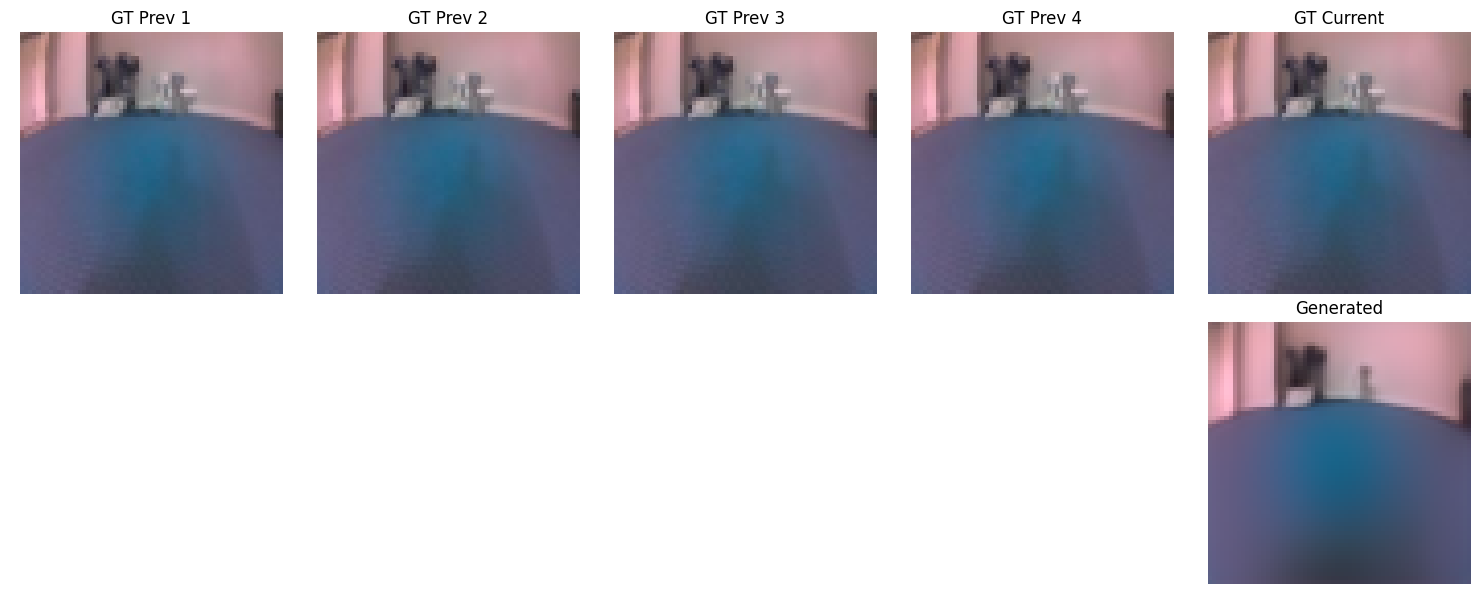

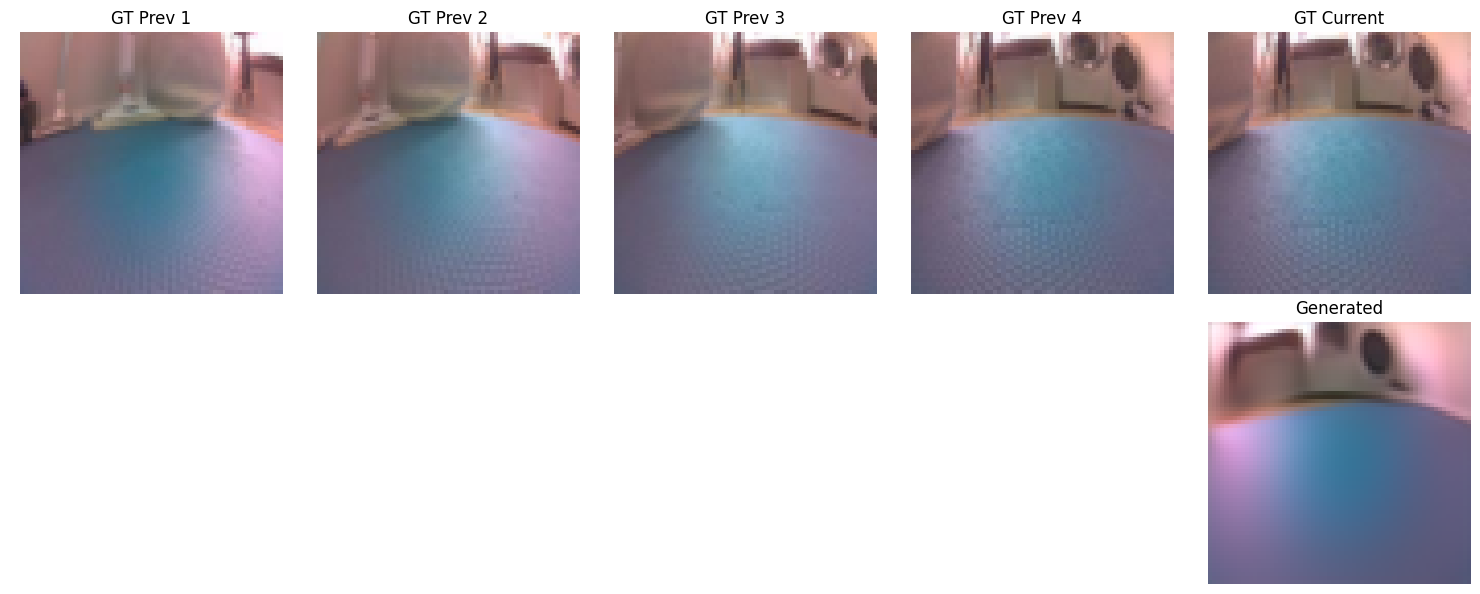

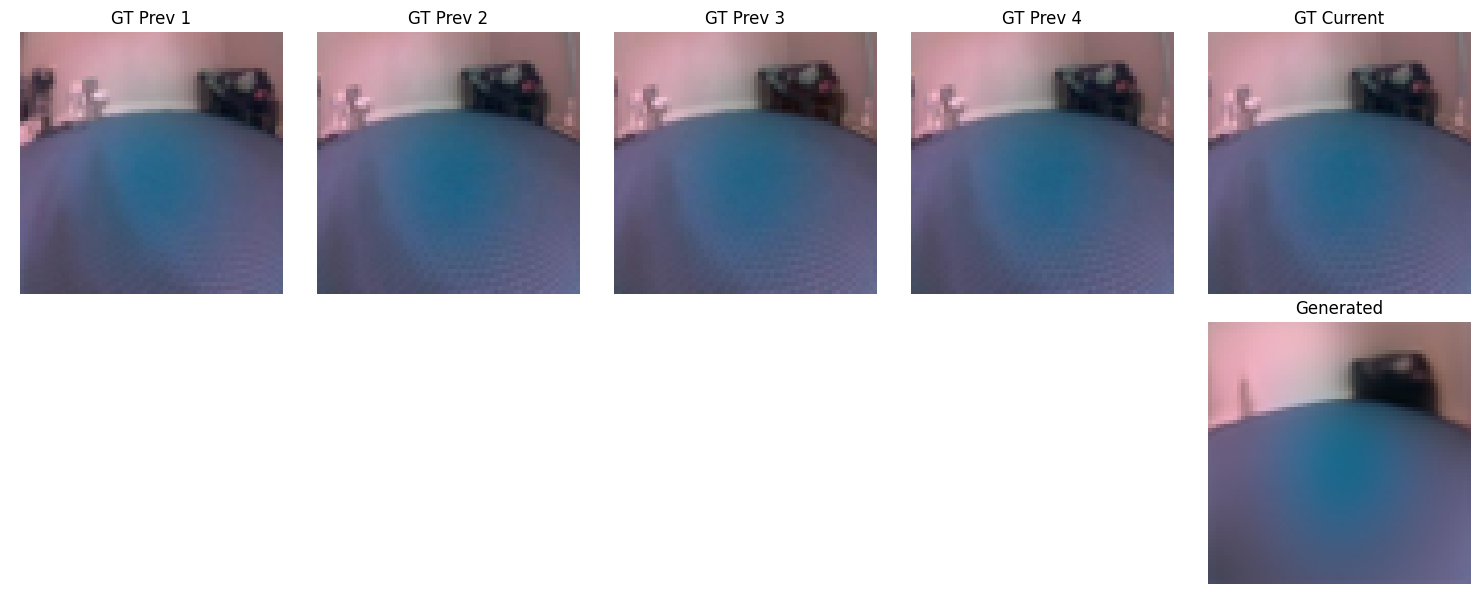

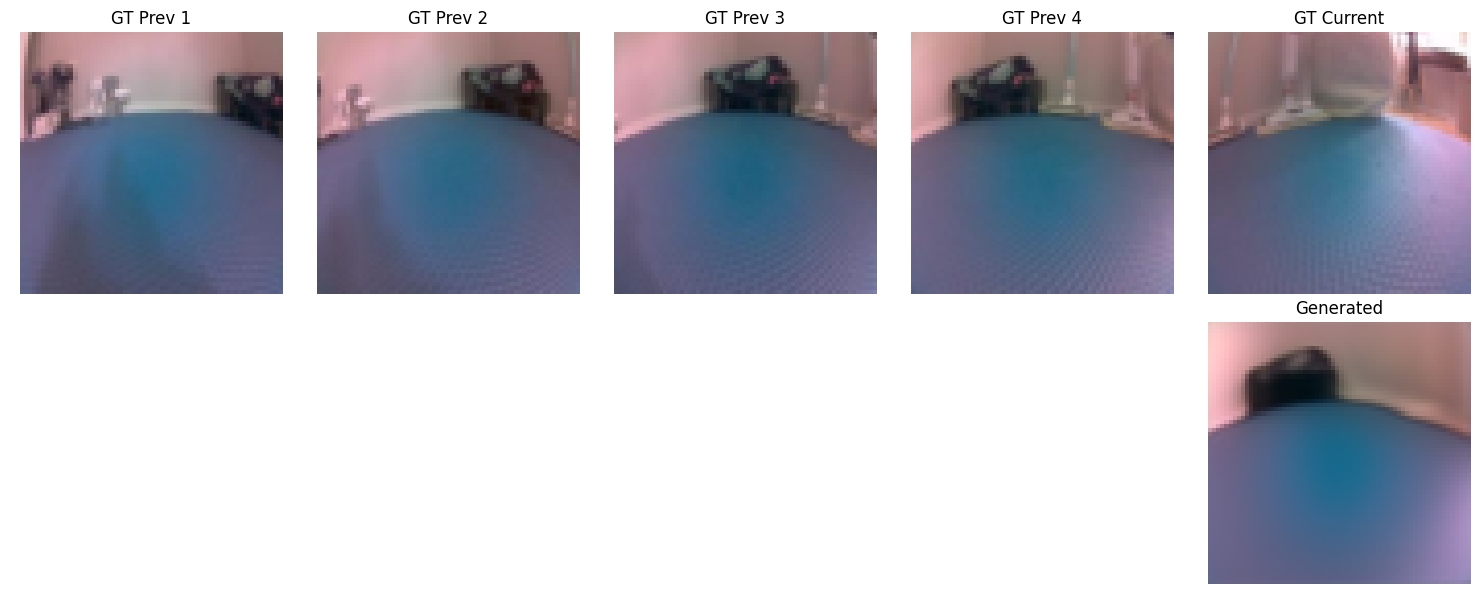